In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds

/Users/yujin/anaconda3/envs/machine_learning/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
iris, iris_info = tfds.load('iris', with_info=True)
print(iris_info)
# tf_dataset들의 데이터셋은 iris['features'] : iris['label'] 와같은 딕셔너리 형태로 저장돼있다.

2024-08-04 16:29:41.284565: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:01<00:00,  1.78s/ url]

Extraction completed...: 100%|██████████| 4/4 [00:01<00:00,  2.22 file/s]
Dl Size...: 0 MiB [00:01, ? MiB/s]
Dl Completed...: 100%|██████████| 1/1 [00:01<00:00,  1.81s/ url]


Dataset iris downloaded and prepared to /Users/yujin/tensorflow_datasets/iris/2.1.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.1.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_dir=PosixGPath('/var/folders/6q/q927ypwn4ll9d4rvjq9gl1qw0000gn/T/tmp5b6exgtltfds'),
    file_format=tfrecord,
    download_size=3.65 KiB,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=float32),
        'label': ClassL

In [11]:
# 데이터 전처리를 테스트셋/훈련셋 나누기

tf.random.set_seed(1)
ds_orig = iris['train']
# 이 데이터는 클래쓰 3개, 각 클래쓰당 50개의 샘플을 가지고 있다.
# 이 샘플을 섞는데, 훈련 샘플과 테스트 샘플이 섞일수도 있으니 reshuffle_each_iteration=False을 반드시 지정해주자.
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)
ds_train_orig = ds_orig.take(100)   # 150개 중에서 100개 가져간다.
ds_test = ds_orig.skip(100)         # 150개 중에서 100개를 생략한다,(50개)

ds_train_orig = ds_train_orig.map(
    lambda x : (x['features'], x['label']))
ds_test = ds_test.map(
    lambda x : (x['features'], x['label']))

print(ds_train_orig)

<_MapDataset element_spec=(TensorSpec(shape=(4,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [23]:

# 데이터셋 출력
print("훈련 데이터셋:")
for features, label in ds_train_orig.take(5):  # 5개 샘플 출력
    print("Features:", features.numpy(), "Label:", label.numpy())

print("\n테스트 데이터셋:")
for features, label in ds_test.take(5):  # 5개 샘플 출력
    print("Features:", features.numpy(), "Label:", label.numpy())

훈련 데이터셋:
Features: [6.5 3.  5.2 2. ] Label: 2
Features: [5.2 3.4 1.4 0.2] Label: 0
Features: [4.9 3.1 1.5 0.1] Label: 0
Features: [6.6 2.9 4.6 1.3] Label: 1
Features: [5.8 2.8 5.1 2.4] Label: 2

테스트 데이터셋:
Features: [5.7 2.5 5.  2. ] Label: 2
Features: [7.2 3.6 6.1 2.5] Label: 2
Features: [5.3 3.7 1.5 0.2] Label: 0
Features: [5.5 2.4 3.8 1.1] Label: 1
Features: [6.4 3.1 5.5 1.8] Label: 2


In [24]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')])
iris_model.summary()
# input_shape=(4,)로 입력층의 입력크기를 입력했음으로 .build()메서드 호출필요 없다.
# 파라미터의 개수는 (N(in)+1)*N(out)이다.
# 예를들어 첫번째 층에서 input_shape=(4,)임으로 N(in)=4, N(out)=16 임으로 파라미터는 16x5 = 80 이다.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
iris_model.compile(optimizer='adam',                        # 최적화기법 선택
                   loss='sparse_categorical_crossentropy',  # 손실함수 선택
                   metrics=['accuracy'])                    # 평가지표로 정확도를 설정했다/

In [26]:
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epochs = np.ceil(training_size/batch_size)
ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)
history = iris_model.fit(ds_train, epochs=num_epochs, steps_per_epoch=steps_per_epochs, verbose=0)
print(history.history) # 훈련 정확도 정보를 담고있다.

{'loss': [1.182130217552185, 1.1165452003479004, 1.075720191001892, 1.0405164957046509, 1.006858229637146, 0.9732665419578552, 0.9385416507720947, 0.9072012901306152, 0.8756474852561951, 0.8373626470565796, 0.8035330772399902, 0.7728464007377625, 0.7425172328948975, 0.710989773273468, 0.685264527797699, 0.6649866700172424, 0.6366007328033447, 0.6158416271209717, 0.5957517027854919, 0.5780068039894104, 0.562849760055542, 0.5489875674247742, 0.5363823175430298, 0.5252087116241455, 0.5100916624069214, 0.49857765436172485, 0.4908198118209839, 0.4798741042613983, 0.4693545997142792, 0.45904281735420227, 0.45188069343566895, 0.4506514370441437, 0.43525031208992004, 0.4283077120780945, 0.4199807643890381, 0.4155900180339813, 0.4079866111278534, 0.40045225620269775, 0.3957761526107788, 0.39450347423553467, 0.38400954008102417, 0.3772997260093689, 0.36911892890930176, 0.363715261220932, 0.3606325387954712, 0.3543073236942291, 0.3506326973438263, 0.3440248370170593, 0.3400556147098541, 0.3328843

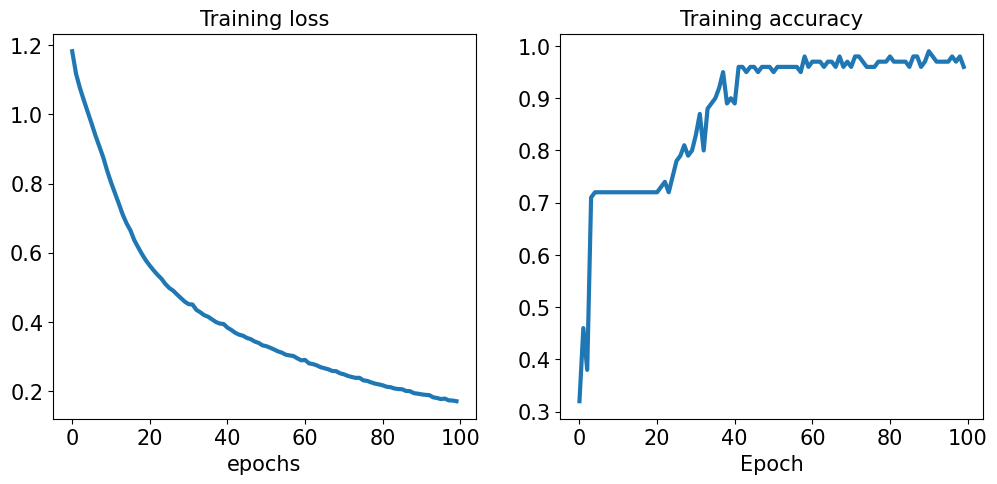

In [27]:
import matplotlib.pyplot as plt

hist = history.history
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('epochs', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [28]:
# 훈련된 모델을 디스크에 저장
# 모델구조와 학습된 모든 파라미터를 저장한다.
iris_model.save('iris_classifier.h5',   # 파일이름
                overwrite=True,         
                include_optimizer=True, 
                save_format='h5') 

# iris_model.save_weights(...) 모델 가중치만 저장
# iris_model.to_json(...)      신경만 구조만 json파일로 저장

/Users/yujin/anaconda3/envs/machine_learning/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
# 저장된 모델을 복원해서 사용하는법
iris_model_new = tf.keras.models.load_model('iris_classifier.h5')

In [30]:
# 훈련된 원본 모듈의 정확도 확인
results = iris_model.evaluate(ds_test.batch(50), verbose=0)
print('테스트 손실 : {:.4f} 테스트 정확도: {:.4f}'.format(*results) )


테스트 손실 : 0.1732 테스트 정확도: 0.9800


In [31]:
# 디스크에서 꺼낸 모듈이 원본과 같은지 확인
results = iris_model_new.evaluate(ds_test.batch(50), verbose=0)
print('테스트 손실 : {:.4f} 테스트 정확도: {:.4f}'.format(*results) )


테스트 손실 : 0.1732 테스트 정확도: 0.9800


callbacks를 이용해서 훈련과정을 제어
일정 에포크 이상으론 훈련결과가 개선되지 않을시에는 조기종료한다. 이를 통해서 컴퓨터 연산량을 줄일수 있을것이다.

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# monitor='val_loss' 검증 손실을 모니터링 한다.
# patience=3 세 번의 에포크 동안 검증 손실이 감소하지 않으면 훈련을 정지하고, 최상의 모델 가중치로 복원한다
# restore_best_weights=True) 검증손실이 감소하지 않으면 최상의 모델 가중치로 복원한다
# filepath='iris_classifier.h5' 학습때마다 가장 좋은 가중치를 저장할 파일
callback_list = [ModelCheckpoint(filepath='iris_classifier.h5', monitor='val_loss'),
                 EarlyStopping(patience=3, restore_best_weights=True)]



In [36]:
model = tf.keras.models.model_from_json(iris_model.to_json())   # 이전 인공신경망 구조만 다시사용하기
model.compile(optimizer='adam',                                 # 최적화기법 선택
                   loss='sparse_categorical_crossentropy',      # 손실함수 선택
                   metrics=['accuracy'])                        # 평가지표로 정확도를 설정했다
history = model.fit(ds_train, epochs=500, 
                    steps_per_epoch=steps_per_epochs, 
                    validation_data=ds_test.batch(50), 
                    callbacks=callback_list, 
                    verbose=0)

/Users/yujin/anaconda3/envs/machine_learning/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


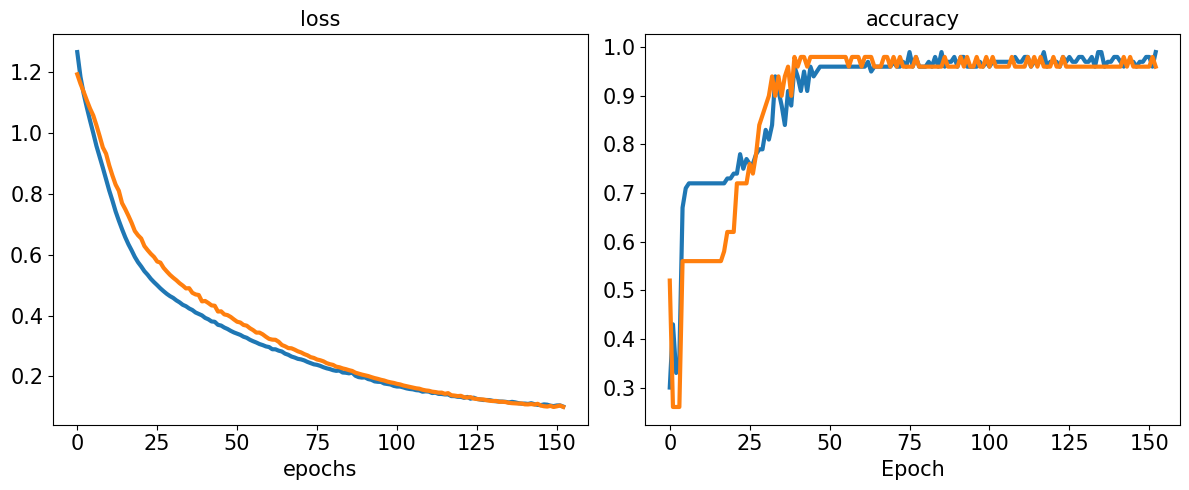

In [37]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.plot(hist['val_loss'], lw=3)
ax.set_title('loss', size=15)
ax.set_xlabel('epochs', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.plot(hist['val_accuracy'], lw=3)
ax.set_title('accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

In [38]:
callback_list[1].stopped_epoch

152